# This notebook examines general trends in FAC data
A more thorough writeup can be found in https://drive.google.com/open?id=1U6stzP7qhqB3B10kNYnWdlgtAibwoFEI6cuKOSSq-ZU

In [50]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import os
import re

processed_path = '/data/ihwang/data_journalism/allfac/processed/'
df_general = pd.read_pickle(processed_path + 'general.pkl')
# print('General DF\n', df_general.head())

# Agency prefix dictionary:
with open(processed_path + 'agency_dict.pkl', 'rb') as f_r:
    agency_dict = pickle.load(f_r)
# Entity code dictionary:
with open(processed_path + 'entity_dict.pkl', 'rb') as f_r:
    entity_dict = pickle.load(f_r)

## Plot percent of all audits by entity class and type

Group by entity class

In [48]:
series_entities = df_general['TYPEOFENTITY'].value_counts().sort_values(ascending=False)
entity_class_dict = {}
for entity in series_entities.index:
    num_audits = series_entities.loc[entity]
    entity_class = entity[0]
    if entity_class not in entity_class_dict.keys():
        entity_class_dict[entity_class] = 0
    entity_class_dict[entity_class] += num_audits

for (entity_class, num_audits) in entity_class_dict.items():
    entity_keys = [i for i in entity_dict.keys() if i[0] == entity_class]
    entity_names = [entity_dict[i] for i in entity_keys]
    if len(entity_names) == 2:
        entity_class_name = '/'.join(entity_names)
    else:
        entity_class_name = os.path.commonprefix(entity_names)
    print(num_audits, '\t', '%s**: %s' %(entity_class, entity_class_name))

369551 	 9**: Non-profit 
145473 	 5**: Independent Education Agency- Institution of Higher Education/Independent Local Education Agency (LEA)
128177 	  **: 
55141 	 2**: Municipality-
43618 	 1**: County-
44133 	 4**: Independent Special District 
21632 	 8**: For profit or outside U.S./UNKNOWN
8140 	 3**: Township-
10873 	 6**: Indian Tribe
10188 	 0**: State-
1291 	 7**: Territory


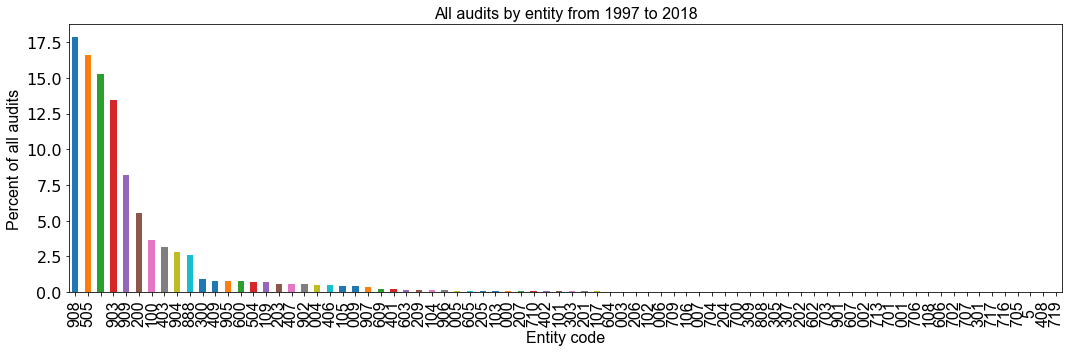

Total number of audits: 838217


In [11]:
fig, axes = plt.subplots(figsize=(15, 5))
entity_groups = df_general.groupby('TYPEOFENTITY').size().sort_values(ascending=False) / len(df_general) * 100
percent_audits_plot = entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('Entity code', fontsize=16, fontname='Arial')
percent_audits_plot.set_xticklabels(labels=entity_groups.index, fontsize=16, fontname='Arial')
percent_audits_plot.set_ylabel('Percent of all audits', fontsize=16, fontname='Arial')
percent_audits_plot.set_title(
    'All audits by entity from %s to %s' %(min(df_general['AUDITYEAR']), max(df_general['AUDITYEAR'])),
    fontsize=16, fontname='Arial'
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(df_general))

## Plot percent of all audits by state

In [ ]:
fig, axes = plt.subplots(figsize=(15, 5))
entity_groups = df_general.groupby('STATE').size().sort_values(ascending=False) / len(df_general) * 100
percent_audits_plot = entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('State', fontsize=16, fontname='Arial')
percent_audits_plot.set_xticklabels(labels=entity_groups.index, fontsize=16, fontname='Arial')
percent_audits_plot.set_ylabel('Percent of all audits', fontsize=16, fontname='Arial')
percent_audits_plot.set_title(
    'All audits by state from %s to %s' %(min(df_general['AUDITYEAR']), max(df_general['AUDITYEAR'])),
    fontsize=16, fontname='Arial'
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(df_general))

## Combining entity type and state

Get top 10 entity types with the most audits, and within each entity type get top states with the most audits

In [ ]:
series_top_entities = df_general['TYPEOFENTITY'].value_counts().head(10)
for (entity, num_audits) in zip(series_top_entities.index, series_top_entities):
    if entity in entity_dict.keys():
        entity_name = entity_dict[entity]
    else:
        entity_name = 'Agency not in dictionary'
    print(num_audits, '\t', entity_name)
    df_entity_states = df_general[df_general['TYPEOFENTITY']==entity]
    series_top_states = df_entity_states['STATE'].value_counts().head(10)
    for (state, num_audits) in zip(series_top_states.index, series_top_states):
        print('\t', num_audits, '\t', state)

Get top 10 states with the most audits, and within each state get top entity types with most of audits

In [ ]:
series_top_states = df_general['STATE'].value_counts().head(10)
for (state, num_audits) in zip(series_top_states.index, series_top_states):
    print(num_audits, '\t', state)
    df_entity_states = df_general[df_general['STATE'] == state]
    series_top_entities = df_entity_states['TYPEOFENTITY'].value_counts().head(10)
    for (entity, num_audits) in zip(series_top_entities.index, series_top_entities):
        if entity in entity_dict.keys():
            entity_name = entity_dict[entity]
        else:
            entity_name = 'Agency not in dictionary'
        print('\t', num_audits, '\t', entity_name)

## "Worst of" findings for select fields
Can select particular year or use all data in order to get aggregate statistics. Each subplot is the "worst of" for the row and column values.
* Financial Statements (TYPEREPORT_FS) and Major Program Compliance (TYPEREPORT_MP): opinion = U, Q, A or D, but focus on Q, A and D since the U's are majority and the other fields are super minorities
* Questioned Costs (QCOSTS), Reportable Condition (REPORTABLECONDITION, REPORTABLECONDITION_MP), Material Noncompliance (MATERIALNONCOMPLIANCE), and Material Weakness (MATERIALWEAKNESS, MATERIALWEAKNESS_MP): finding = primarily Y or N

In [ ]:
df_plot = df_general.copy(deep=True)
# df_plot = df_general[df_general['AUDITYEAR'] == 2018]

In [ ]:
fields = ['TYPEREPORT_FS', 'QCOSTS', 'MATERIALWEAKNESS', 'MATERIALNONCOMPLIANCE']
# fields = ['TYPEREPORT_MP', 'REPORTABLECONDITION_MP', 'MATERIALWEAKNESS_MP']
sortbys = ['STATE', 'TYPEOFENTITY', 'OVERSIGHTAGENCY']
print('Possible field types:')
for field in fields:
    print('%s: %s' %(field, ', '.join(set(df_general[field]))))

In [ ]:
fig, axes = plt.subplots(nrows=len(sortbys), ncols=len(fields), figsize=(len(fields)*5, 10))
for (i, sortby) in enumerate(sortbys):
    for (j, field) in enumerate(fields):
        series_grouped = df_plot.groupby(sortby)[field].value_counts()
        df_grouped = series_grouped.unstack()
        df_grouped_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)
        if 'TYPEREPORT' in field:
            df_select_fields = df_grouped_normalized[
                [i for i in df_grouped_normalized.columns if i in ['A', 'D']]
            ]
            top_sortby = df_select_fields.sort_values(['D', 'A'], ascending=False).head(10).index
        else:
            df_select_fields = df_grouped_normalized[
                [i for i in df_grouped_normalized.columns if i in ['Y', 'N', 'X']]
            ]
            top_sortby = df_select_fields['Y'].sort_values(ascending=False).head(10).index
        df_select_sorted = df_select_fields.reindex(index=top_sortby)
        plot_top_sorted = df_select_sorted.plot(
            kind='bar', fontsize=16, stacked=True, ax=axes[i, j]
        )
        if i == 0:
            plot_top_sorted.set_title(field, fontsize=18, fontname='Arial')
        plot_top_sorted.set_xticklabels(labels=df_select_sorted.index, fontsize=16, fontname='Arial')
        plot_top_sorted.set_xlabel(sortby, fontsize=16, fontname='Arial')
plt.tight_layout()
plt.show()

## Follow the money!

In [131]:
year = 2018
data = []
with open('/data/ihwang/data_journalism/allfac/raw/cfda.txt', 'r', encoding = 'ISO-8859-1') as f_cfda:
    for line in f_cfda:
        fields = line.strip().split(',')
        if fields[0] == 'AUDITYEAR':
            header = fields
        else:
            [AUDITYEAR, DBKEY] = [int(fields[0]), int(fields[1])]
            if AUDITYEAR == year:
                EIN = int(fields[2])
                CFDA = re.sub(r'[^\.\w]', '', fields[3])
                CFDA_PREFIX = CFDA.split('.')[0]
                CFDA_EXTENSION = CFDA.split('.')[1]
                FEDERALPROGRAMNAME = re.sub(r'[\W]+', ' ', fields[6].strip())
                AMOUNT = int(fields[7])
                data.append([AUDITYEAR, DBKEY, EIN, CFDA_PREFIX, CFDA_EXTENSION, FEDERALPROGRAMNAME, AMOUNT])

In [132]:
df_cfda = pd.DataFrame(data, columns=['AUDITYEAR', 'DBKEY', 'EIN', 'CFDA_PREFIX', 'CFDA_EXTENSION', 'FEDERALPROGRAMNAME', 'AMOUNT'])

Join `df_cfda` with `df_general` to have all fields in the same dataframe

In [214]:
df_general_cfda = df_cfda.merge(df_general, how='left', on=['AUDITYEAR', 'DBKEY'])

In [216]:
series_cfda_state_entity_amount = df_general_cfda.groupby(['CFDA_PREFIX','STATE', 'TYPEOFENTITY'])['AMOUNT'].sum()

In [224]:
pd.DataFrame(series_cfda_state_entity_amount).sort_values(['AMOUNT', 'CFDA_PREFIX'], ascending=False)

AMOUNT
CFDA_PREFIX STATE TYPEOFENTITY             
93          NY    000           49776256000
84          NY    909           14523885610
            TX    004           10846842193
10          NY    000            7006199000
84          TX    904            6480904289
            NY    000            4004735000
            CA    505            3542043477
14          NY    000            2815221000
17          NY    000            2663711000
84          TX    505            2646974923
93          UT    000            2606103846
84          OH    004            2379053165
            CA    904            2202817393
10          CA    505            2004671316
84          PA    904            1941311283
93          CA    908            1937880244
84          UT    000            1868766119
20          NY    000            1852022000
10          TX    505            1755932648
84          MA    904            1748770984
93          FL    908            1745745482
84          FL    904            1712430720
14          VA    003            1708592355
84          MO    009            1672714000
            IL    904            1665766659
97          NY    000            1551058000
84          CA    504            1516507784
            NC    004            1470760265
                  009            1469981916
            TX    504            1457617888
...                                     ...
10          PA    902                   120
19          OR    100                   111
17          LA    505                   100
39          PA    904                    66
43          TX    100                    59
64          MA    300                    55
94          GA    904                    52
            KS    888                    50
66          MT    505                    32
96          CT    200                    25
97          OK    505                     0
47          AK    205                     0
21          MT    505                     0
16          CA    401                     0
77          SC    909                   -13
14          KY    004                  -433
12          MO    904                  -447
45          OR    004                  -887
43          LA    904                 -2094
81          AL    004                 -2491
97          ND    505                 -7263
17          NY    904                 -9760
99          VT    904                -31334
66          CA    902                -47036
97          TX    102                -66268
84          SC    909                -94911
12          SC    909               -105183
94          LA    904               -134375
16          MA    006               -170296
14          NY    009               -406352

[6049 rows x 1 columns]